In [1]:
## Init Bionic VTOL
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode
create_visualization();

# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()
### Create Reinforcement Learning Environment


################################ TODO ################################
# You can initialization global constants here.
# E.g. a fixed point in the beginning of training (for testing/overfitting)
# Define global constants for initial position and rotation

#####
##### first coordinate - red axis - x
##### second coordinate - green axis - y
##### third coordinate - blue axis - z
#####
x_init = [0.0, 0.0, 0.0];
rot_init = Matrix(UnitQuaternion(RotZ(-pi/2.0) * RotY(-pi/2.0) * RotX(pi)));

# Defaault values for VtolEnv variables
waypoints_default = generate_trajectory(2);
proximity_tolerance_default = 0.25;
timeout_default = 30.0;

v_min_default = 1.0;
v_max_default = 2.0;
w_max_default = 15.0;;

######################################################################

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


In [10]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environments
    visualization::Bool # visualization
    realtime::Bool # realtime

    x_previous::Vector{T} # previous position
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    w_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    delta_t::T # simulation time step

    ################################ TODO ################################
    # Extend the environment here.
    # Everything you need additionaly in your environment also go in here.
    # E.g. a trajectory

    # Pathway variables
    waypoints::Vector{Vector{T}}
    proximity_tolerance::T
    timeout::T

    # Kinetic variables
    v_min::T
    v_max::T # maximum allowed velocity
    w_max::T # maximum allowed velocity

    ######################################################################
end


# define a keyword-based constructor for the type declared in the mutable struct typedef.
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # random number generation
    name = "vtol",
            visualization = false,
    realtime = false,
    kwargs...) # let the function take an arbitrary number of keyword arguments

    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    A = Space{Vector{ClosedInterval{T}}};

    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ],
    ) # propeller 1 and 2

    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            ################################ TODO ################################
            # Implement an observation space.
            # Here is an example space. You can change it if desired.
            # You have to extend it.
            # Orientate yourself on the observation space from the paper.

            typemin(T)..typemax(T), #1 previous position along x WORLD coordinates
            typemin(T)..typemax(T), #2 previous position along z WORLD coordinates

            typemin(T)..typemax(T), #3 current position along x WORLD coordinates
            typemin(T)..typemax(T), #4 current position along z WORLD coordinates

            typemin(T)..typemax(T), #7 velocity along x BODY coordinates
            typemin(T)..typemax(T), #8 velocity along y BODY coordinates

            typemin(T)..typemax(T), #9 rotational velocity along z BODY coordinates
            ######################################################################
            ],
    )

    if visualization # visualizes VTOL
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
    end

    environment = VtolEnv(
        action_space, # action space
        state_space, # observation space
        zeros(T, length(state_space)), # current state space
        rand(action_space), # initialization action
        false, # episode done
        0.0, # time
        rng, # random number generator

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_previous, previous position
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        rot_init, # R_W, current rotation
        zeros(T, 3), # w_B
        zeros(T, 3), # wind_W
        T(0.02), # simulation time step

        ################################## TODO ##################################
        # Initialization everything you need additionaly in your environment here

        waypoints_default,
        proximity_tolerance_default,
        timeout_default,
        v_min_default,
        v_max_default,
        w_max_default,
        ##########################################################################
    )

    reset!(environment)
    return environment
end;

methods(VtolEnv)

# Just for explanation:
# 1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
# 2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.'
# So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

## Define the RL interface

Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

function computeReward(env::VtolEnv{A,T}) where {A,T}
    reward = 0.0

    ################################ TODO ################################
    # Implement the reward function.
    # Orientate on the paper.

    # Hyperparameters
    kp = 5.0;
    kw = 0.01;
    kwp = 5.0;
    # max distance
    dmax = 0.3;

    # Gates and their length
    gates = env.waypoints;
    n = length(gates);

    # closest point on the guiding path phi
    # its line-segment index lp
    x_old = [env.state[1], 0.0, env.state[2]];
    x_new = [env.state[3], 0.0, env.state[4]];
    lp_old, phi_old = calculate_progress(gates, x_old);
    lp_new, phi_new = calculate_progress(gates, x_new);

    # previous time step spt_old
    # current time step spt_new
    spt_old = norm(phi_old - gates[lp_old]);
    spt_new = norm(phi_new - gates[lp_new]);

    # rogress reward rpt at time t is as a difference in reached
    # distance between the current and previous time step
    rpt = spt_new - spt_old
    spt = spt_new

    # The sum that is later going to be the divisor
    # for the reached distance reward
    divisor_g = norm(gates[2] - gates[1]);

    # reached distance reward ks
    ks = 2 * env.v_max * env.delta_t / divisor_g;

    # steered at waypoint must be 1 bigger than the current line segment
    # distance to new waypoint dw
    dwp = norm(x_new - gates[2]);
    # tolerance for proximity to a waypoint
    r_tol = env.proximity_tolerance;

    # waypoint reward rwp
    rwp = dwp <= r_tol ? exp(-dwp/r_tol) : 0.0;

    # no obstacles
    collision = false;
    # terminal reward rt
    rt = collision ? 10 : 0;

    # absolute velocity
    v_vector = [env.state[5], env.state[6], 0.0]
    v = norm(v_vector);
    # rotation speed
    w = abs(env.state[7]);
    # distance from closes point on the guiding path
    gd = norm(x_new - phi_new);

    # Scaling factors
    svmax = v > env.v_max ? 10^(env.v_max - v) : 1.0;
    svmin = v < env.v_min ?  10^(v - env.v_min) : 1.0;
    sgd = gd > dmax  ? exp(dmax - gd) : 1.0;

    # Ultimate scaling factor
    s = svmax * svmin * sgd;

    # Scaling the rewards
    kp = s * kp;
    ks = s * ks;

    #### Punishment for stupidity and autism
    # Punish for falling down
    kz = 1.5 / (1.0 + env.t);
    rz = (min(0, env.state[4]))^2;
    # Punish for attempting to quickly end the simulation at the beginning due to high rotation acceleration
    rz += (w * max(0, 0.5 - env.t))^2;
    kw *= max(1.0, 4.0 - env.t);

    # Sum up positive reinforcement and negative reinforcement
    positive_r = kp * rpt + ks * spt + kwp * rwp;
    negative_r = kw * w + rt + kz * rz;

    # Sum it all
    reward = positive_r - negative_r;

    # Increase reward for better timing after performance threshold
    perf_th = 1.0;
    if(reward > perf_th)
        reward *= (1.0 / (dwp^2 * env.t))
        if(dwp < env.proximity_tolerance)
            reward *= reward;
        end
    end


    ################################################################################################

    return reward
end

RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end

    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = rot_init;

    env.w_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];

    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    ################################ TODO ################################
    # Reset environment.
    # Is called if the training terminates
    # (e.g. if drone crashes or successfully reaches point)
    # HINT: Everything you added to your environment needs to be reseted.
    #       Compare it with the initialization.

    env.state[1] = env.x_previous[1]; # update previous x-coordinate
    env.state[2] = env.x_previous[3]; # update previous z-coordinate

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[7] = env.w_B[3];  # rotational velocity along z BODY coordinates

    env.x_previous = x_init; # starting position
    env.delta_t = T(0.02); # Δ time

    env.waypoints = waypoints_default;
    env.proximity_tolerance = proximity_tolerance_default;
    env.timeout = timeout_default;
    env.v_min = v_min_default;
    env.v_max = v_max_default;
    env.w_max = w_max_default;

    # Visualize the waypoints
    radius = 0.1;
    visualize_waypoints(env.waypoints, radius);
    ######################################################################

    nothing
end;

# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # set the propeller trust and the two flaps 2D case
    # flaps set to 0.0
    next_action = [a[1], a[2], 0.0, 0.0]

    _step!(env, next_action)
end

env = VtolEnv();
methods(env) # Just to explain which methods the object has


function _step!(env::VtolEnv, next_action)
    # Update previous
    env.x_previous = [env.state[3], 0.0, env.state[4]];

    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W);

    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);

    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0;
    torque_B[2] = 0.0;  # Body X and Y
    env.w_B[1] = 0.0;
    env.w_B[2] = 0.0;

    # integrate rigid body dynamics for delta_t
    env.x_W, env.v_B, env.R_W, env.w_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.w_B, env.t, env.delta_t, eth_vtol_param);

    if env.realtime
        sleep(env.delta_t); # just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action);
    end

    env.t += env.delta_t


    ################################ TODO ################################

    env.state[1] = env.x_previous[1]; # update previous x-coordinate
    env.state[2] = env.x_previous[3]; # update previous z-coordinate

    env.state[3] = env.x_W[1]; # position along x
    env.state[4] = env.x_W[3]; # position along z

    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates

    env.state[7] = env.w_B[3];  # rotational velocity along z BODY coordinates

    # Instead of the floor level which assumes the simulation will only run upstairs,
    # Here a variables for being too far from the next wp after reaching a previous waypoint can be used instead

    segment_length = norm(env.waypoints[2] - env.waypoints[1])
    k_failure = 1.5;
    wp_dist = norm(env.waypoints[2] - env.x_W)

    env.done =
        norm(env.w_B) > env.w_max || # stop if body rate is too high
        wp_dist > k_failure * segment_length ||
        env.t > env.timeout ||
        wp_dist < env.proximity_tolerance;
    ######################################################################

    nothing
end;

RLBase.test_runnable!(env)

# changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)
# Show an overview of the environment.

## Setup of a reinforcement learning experiment.

seed = 123
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024

    vtol_envs = [
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ];
    # define multiple environments for parallel training
    env = MultiThreadEnv(vtol_envs)

    # Define the function approximator
    # TODO: research briefly what Actor Critic is
    # TODO: research what ADAM is
    # Define the function approximator
    ns, na = length(state(env[1])), length(action_space(env[1]))
    #ActorCritic Policy
    approximator = ActorCritic(
                #ns - number states as input
                #3 layer; last layer splitted in mean and variance; then action is sampled
                actor = GaussianNetwork(
                    pre = Chain(
                        Dense(ns, 32, relu; initW = glorot_uniform(rng)),
                        Dense(32, 16, relu; initW = glorot_uniform(rng)),
                        Dense(16, 16, relu; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(
                        Dense(16, na; initW = glorot_uniform(rng))
                    ),
                    logσ = Chain(
                        Dense(16, na; initW = glorot_uniform(rng))
                    ),
                ),
                critic = Chain(
                    Dense(ns, 32, relu; initW = glorot_uniform(rng)),
                    Dense(32, 16, relu; initW = glorot_uniform(rng)),
                    Dense(16, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

        agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # (optional) TODO: change eventually
        # TODO: research briefly what PPO is
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),

        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)
    f = joinpath("./RL_models_2dpoint_leo/", "vtol_2D_ppo_$t.bson") # TODO: save model here
    @save f model
    println("parameters at step $t saved to $f")
end;

function loadModel()
    f = joinpath("./RL_models_2dpoint_leo/", "vtol_2D_ppo_1500000.bson") # TODO: load model here
    @load f model
    return model
end;

function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")

end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);



Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  0.0s


In [ ]:
# Run without loading the model

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

In [11]:
# Run with loading the model

agent.policy.approximator = loadModel();

ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(1_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000),
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   1%|▎                                        |  ETA: 0:05:10

test reward at step 10000: 368.08989429878403


Progress:   1%|▌                                        |  ETA: 0:10:22

test reward at step 20000: -1.3451597546200769


Progress:   2%|▉                                        |  ETA: 0:08:37

test reward at step 30000: 1487.7193110670382


Progress:   3%|█▏                                       |  ETA: 0:08:39

test reward at step 40000: 327.9178475562236


Progress:   3%|█▎                                       |  ETA: 0:09:10

test reward at step 50000: 467.5061060895106


Progress:   4%|█▌                                       |  ETA: 0:08:53

test reward at step 60000: 546.8797897699261


Progress:   5%|█▉                                       |  ETA: 0:08:42

test reward at step 70000: 20167.981248890355


Progress:   5%|██▏                                      |  ETA: 0:08:32

test reward at step 80000: 474.5308564389741


Progress:   6%|██▍                                      |  ETA: 0:08:42

test reward at step 90000: 4868.588556376358


Progress:   7%|██▋                                      |  ETA: 0:08:32

parameters at step 100000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_100000.bson
test reward at step 100000: -0.16988773558436332


Progress:   7%|███                                      |  ETA: 0:08:38

test reward at step 110000: -0.46452835338332366


Progress:   8%|███▎                                     |  ETA: 0:08:42

test reward at step 120000: 1228.6125175147783


Progress:   9%|███▌                                     |  ETA: 0:08:37

test reward at step 130000: 6647.592332334452


Progress:   9%|███▉                                     |  ETA: 0:08:51

test reward at step 140000: 1184.8909293122824


Progress:  10%|████                                     |  ETA: 0:08:38

test reward at step 150000: 336.3621303532896


Progress:  10%|████▎                                    |  ETA: 0:08:32

test reward at step 160000: 724.9188732080951


Progress:  11%|████▋                                    |  ETA: 0:08:26

test reward at step 170000: 321.1040286528959


Progress:  12%|████▉                                    |  ETA: 0:08:18

test reward at step 180000: 6807.107579463913


Progress:  12%|█████▏                                   |  ETA: 0:08:21

test reward at step 190000: 924.0945193917667


Progress:  13%|█████▍                                   |  ETA: 0:08:14

parameters at step 200000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_200000.bson
test reward at step 200000: 647.8509802295999


Progress:  14%|█████▊                                   |  ETA: 0:08:06

test reward at step 210000: 403.8138296961058


Progress:  14%|█████▉                                   |  ETA: 0:08:09

test reward at step 220000: 7274.155107011533


Progress:  15%|██████▎                                  |  ETA: 0:08:02

test reward at step 230000: 93723.93090878148


Progress:  16%|██████▌                                  |  ETA: 0:07:55

test reward at step 240000: 308.5297887346467


Progress:  17%|██████▉                                  |  ETA: 0:07:48

test reward at step 250000: 1378.4927750122997


Progress:  17%|███████                                  |  ETA: 0:07:51

test reward at step 260000: 3567.91151241294


Progress:  18%|███████▍                                 |  ETA: 0:07:44

test reward at step 270000: 310.48946740027134


Progress:  19%|███████▋                                 |  ETA: 0:07:52

test reward at step 280000: -0.3399720630312263


Progress:  19%|███████▊                                 |  ETA: 0:07:45

test reward at step 290000: 5054.330104550911


Progress:  20%|████████▏                                |  ETA: 0:07:39

parameters at step 300000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_300000.bson
test reward at step 300000: 405.78832066044606


Progress:  21%|████████▌                                |  ETA: 0:07:41

test reward at step 310000: 25420.06140208683


Progress:  21%|████████▋                                |  ETA: 0:07:34

test reward at step 320000: 6443.989093747529


Progress:  22%|█████████                                |  ETA: 0:07:28

test reward at step 330000: 509.2575234745261


Progress:  23%|█████████▎                               |  ETA: 0:07:23

test reward at step 340000: -0.04479705939664283


Progress:  23%|█████████▍                               |  ETA: 0:07:26

test reward at step 350000: 1.954711308929321


Progress:  24%|█████████▊                               |  ETA: 0:07:23

test reward at step 360000: 3587.2758460422365


Progress:  25%|██████████                               |  ETA: 0:07:18

test reward at step 370000: 611.7641201536302


Progress:  25%|██████████▍                              |  ETA: 0:07:13

test reward at step 380000: 1182.5426601849176


Progress:  26%|██████████▌                              |  ETA: 0:07:13

test reward at step 390000: 4993.527874492867


Progress:  26%|██████████▉                              |  ETA: 0:07:07

parameters at step 400000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_400000.bson
test reward at step 400000: 331.8676987861673


Progress:  27%|███████████▎                             |  ETA: 0:07:01

test reward at step 410000: 744.4761488123785


Progress:  28%|███████████▌                             |  ETA: 0:07:01

test reward at step 420000: 435.49379344925944


Progress:  28%|███████████▋                             |  ETA: 0:06:57

test reward at step 430000: 1866.237753252818


Progress:  29%|████████████                             |  ETA: 0:06:51

test reward at step 440000: 7318.910974171681


Progress:  30%|████████████▎                            |  ETA: 0:06:47

test reward at step 450000: 285.7497992302657


Progress:  31%|████████████▋                            |  ETA: 0:06:42

test reward at step 460000: 304.3415887788244


Progress:  31%|████████████▊                            |  ETA: 0:06:42

test reward at step 470000: -2.3560990342336896


Progress:  32%|█████████████                            |  ETA: 0:06:38

test reward at step 480000: 2363.0116880600585


Progress:  33%|█████████████▍                           |  ETA: 0:06:33

test reward at step 490000: 966.4173540900804


Progress:  33%|█████████████▋                           |  ETA: 0:06:29

parameters at step 500000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_500000.bson
test reward at step 500000: 5003.195924881813


Progress:  34%|█████████████▊                           |  ETA: 0:06:28

test reward at step 510000: 1311.1499112646866


Progress:  34%|██████████████▏                          |  ETA: 0:06:23

test reward at step 520000: 2.1849983257871584


Progress:  35%|██████████████▍                          |  ETA: 0:06:20

test reward at step 530000: 2.8520034880187466


Progress:  36%|██████████████▊                          |  ETA: 0:06:16

test reward at step 540000: -0.5680599815609618


Progress:  36%|██████████████▉                          |  ETA: 0:06:16

test reward at step 550000: -0.2343714276793361


Progress:  37%|███████████████▎                         |  ETA: 0:06:11

test reward at step 560000: -1.221138329986628


Progress:  38%|███████████████▋                         |  ETA: 0:06:06

test reward at step 570000: -5.857725874308936


Progress:  39%|███████████████▉                         |  ETA: 0:06:08

test reward at step 580000: 0.6897162047373572


Progress:  39%|████████████████                         |  ETA: 0:06:03

test reward at step 590000: 1968.2328277269391


Progress:  40%|████████████████▍                        |  ETA: 0:05:58

parameters at step 600000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_600000.bson
test reward at step 600000: 482.014021534573


Progress:  41%|████████████████▋                        |  ETA: 0:05:53

test reward at step 610000: 521.8915970284338


Progress:  41%|█████████████████                        |  ETA: 0:05:50

test reward at step 620000: 20352.885803831574


Progress:  42%|█████████████████▏                       |  ETA: 0:05:46

test reward at step 630000: 348.46517072789953


Progress:  42%|█████████████████▍                       |  ETA: 0:05:41

test reward at step 640000: -3.0196140564793876


Progress:  43%|█████████████████▊                       |  ETA: 0:05:37

test reward at step 650000: -2.5021377554115367


Progress:  44%|█████████████████▉                       |  ETA: 0:05:36

test reward at step 660000: -1.9839104548097555


Progress:  44%|██████████████████▎                      |  ETA: 0:05:32

test reward at step 670000: -1.2029481616304707


Progress:  45%|██████████████████▌                      |  ETA: 0:05:27

test reward at step 680000: 0.44881270483782904


Progress:  46%|██████████████████▊                      |  ETA: 0:05:27

test reward at step 690000: -1.1492953197999607


Progress:  46%|███████████████████                      |  ETA: 0:05:23

parameters at step 700000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_700000.bson
test reward at step 700000: 653.0524206172973


Progress:  47%|███████████████████▍                     |  ETA: 0:05:17

test reward at step 710000: -0.06976761945142379


Progress:  48%|███████████████████▋                     |  ETA: 0:05:13

test reward at step 720000: 4258.362115314725


Progress:  48%|███████████████████▊                     |  ETA: 0:05:11

test reward at step 730000: 2012.9387072674745


Progress:  49%|████████████████████▏                    |  ETA: 0:05:06

test reward at step 740000: 1.0813423099620492


Progress:  50%|████████████████████▌                    |  ETA: 0:05:01

test reward at step 750000: 25267.40869809719


Progress:  51%|████████████████████▊                    |  ETA: 0:04:56

test reward at step 760000: 884.661726716915


Progress:  51%|████████████████████▉                    |  ETA: 0:04:54

test reward at step 770000: -0.40066108654354143


Progress:  52%|█████████████████████▎                   |  ETA: 0:04:50

test reward at step 780000: 1.7871439027677454


Progress:  53%|█████████████████████▌                   |  ETA: 0:04:46

test reward at step 790000: 6012.609710456446


Progress:  53%|█████████████████████▉                   |  ETA: 0:04:41

parameters at step 800000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_800000.bson
test reward at step 800000: 834.9581983219056


Progress:  54%|██████████████████████▏                  |  ETA: 0:04:37

test reward at step 810000: 1503.5976961048502


Progress:  54%|██████████████████████▎                  |  ETA: 0:04:34

test reward at step 820000: 512.6907059588003


Progress:  55%|██████████████████████▋                  |  ETA: 0:04:28

test reward at step 830000: 9655.033633539626


Progress:  56%|███████████████████████                  |  ETA: 0:04:23

test reward at step 840000: 0.5620880735607253


Progress:  56%|███████████████████████▏                 |  ETA: 0:04:22

test reward at step 850000: 489.14818215026037


Progress:  57%|███████████████████████▍                 |  ETA: 0:04:17

test reward at step 860000: -0.5301690841982508


Progress:  58%|███████████████████████▊                 |  ETA: 0:04:12

test reward at step 870000: 2365.1871506766784


Progress:  59%|████████████████████████                 |  ETA: 0:04:09

test reward at step 880000: 354.22309850133996


Progress:  59%|████████████████████████▎                |  ETA: 0:04:05

test reward at step 890000: 411.1621877386425


Progress:  60%|████████████████████████▌                |  ETA: 0:04:00

parameters at step 900000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_900000.bson
test reward at step 900000: 1775.6054641498013


Progress:  60%|████████████████████████▊                |  ETA: 0:03:58

test reward at step 910000: 2357.8441816939667


Progress:  61%|█████████████████████████                |  ETA: 0:03:52

test reward at step 920000: -0.06796270612981276


Progress:  62%|█████████████████████████▍               |  ETA: 0:03:47

test reward at step 930000: 0.34452085473049987


Progress:  62%|█████████████████████████▌               |  ETA: 0:03:45

test reward at step 940000: -0.3063131765087215


Progress:  63%|█████████████████████████▉               |  ETA: 0:03:40

test reward at step 950000: 0.31713562591484695


Progress:  64%|██████████████████████████▎              |  ETA: 0:03:35

test reward at step 960000: 0.032857629126361754


Progress:  64%|██████████████████████████▍              |  ETA: 0:03:34

test reward at step 970000: -2.9022045800176364


Progress:  65%|██████████████████████████▊              |  ETA: 0:03:28

test reward at step 980000: 0.4220098986896461


Progress:  66%|███████████████████████████              |  ETA: 0:03:23

test reward at step 990000: -1.2065792525088854


Progress:  66%|███████████████████████████▎             |  ETA: 0:03:21

parameters at step 1000000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1000000.bson
test reward at step 1000000: -0.937532472558156


Progress:  67%|███████████████████████████▌             |  ETA: 0:03:16

test reward at step 1010000: -1.2501379372675956


Progress:  68%|███████████████████████████▊             |  ETA: 0:03:14

test reward at step 1020000: 337.1310254508072


Progress:  68%|████████████████████████████             |  ETA: 0:03:09

test reward at step 1030000: 1220.0239438831136


Progress:  69%|████████████████████████████▍            |  ETA: 0:03:04

test reward at step 1040000: 2437.337116201865


Progress:  70%|████████████████████████████▋            |  ETA: 0:02:59

test reward at step 1050000: 3805.0025213715185


Progress:  70%|████████████████████████████▉            |  ETA: 0:02:57

test reward at step 1060000: 8754.763327117684


Progress:  71%|█████████████████████████████▏           |  ETA: 0:02:52

test reward at step 1070000: 2894.462487491428


Progress:  72%|█████████████████████████████▌           |  ETA: 0:02:47

test reward at step 1080000: 769.3006847061337


Progress:  73%|█████████████████████████████▊           |  ETA: 0:02:42

test reward at step 1090000: 0.6547439529314106


Progress:  73%|█████████████████████████████▉           |  ETA: 0:02:40

parameters at step 1100000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1100000.bson
test reward at step 1100000: 804.2313113371779


Progress:  74%|██████████████████████████████▎          |  ETA: 0:02:35

test reward at step 1110000: -2.2174731922121955


Progress:  75%|██████████████████████████████▋          |  ETA: 0:02:31

test reward at step 1120000: -143.04405318022236


Progress:  75%|██████████████████████████████▊          |  ETA: 0:02:28

test reward at step 1130000: -3.643924037248025


Progress:  76%|███████████████████████████████▏         |  ETA: 0:02:23

test reward at step 1140000: 5319.691539861118


Progress:  77%|███████████████████████████████▍         |  ETA: 0:02:18

test reward at step 1150000: -2.405149641287195


Progress:  77%|███████████████████████████████▋         |  ETA: 0:02:16

test reward at step 1160000: -1.106289529701517


Progress:  78%|███████████████████████████████▉         |  ETA: 0:02:12

test reward at step 1170000: -1.0487631616230746


Progress:  79%|████████████████████████████████▎        |  ETA: 0:02:07

test reward at step 1180000: -4.556410329406753


Progress:  79%|████████████████████████████████▍        |  ETA: 0:02:05

test reward at step 1190000: -4.688121638336507


Progress:  80%|████████████████████████████████▊        |  ETA: 0:02:00

parameters at step 1200000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1200000.bson
test reward at step 1200000: 22590.245823502777


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:01:55

test reward at step 1210000: 4464.210260745582


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:01:53

test reward at step 1220000: 1194.2646063548589


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:01:48

test reward at step 1230000: 400.56875183650266


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:01:43

test reward at step 1240000: 893.6419410708008


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:01:39

test reward at step 1250000: -135.82091287868522


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:01:36

test reward at step 1260000: -4.990695454753553


Progress:  84%|██████████████████████████████████▋      |  ETA: 0:01:32

test reward at step 1270000: 13832.705155001706


Progress:  85%|███████████████████████████████████      |  ETA: 0:01:27

test reward at step 1280000: 24982.59994314529


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:01:23

test reward at step 1290000: -3.7984936555638327


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:01:20

parameters at step 1300000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1300000.bson
test reward at step 1300000: -14.328284709267948


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:01:15

test reward at step 1310000: -4.5048059944071905


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:01:11

test reward at step 1320000: -9.413497062710102


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:01:08

test reward at step 1330000: 711.7633571911251


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:01:04

test reward at step 1340000: 417.5612576421706


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:59

test reward at step 1350000: 0.14274166365851987


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:57

test reward at step 1360000: -6.634868230567075


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:52

test reward at step 1370000: 584.7060490744572


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:48

test reward at step 1380000: -151.77498518316358


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:45

test reward at step 1390000: -0.4714998600645346


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:41

parameters at step 1400000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1400000.bson
test reward at step 1400000: 902.2207925203368


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:36

test reward at step 1410000: -31.95395363820125


Progress:  94%|██████████████████████████████████████▊  |  ETA: 0:00:34

test reward at step 1420000: -33.006459279652844


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:29

test reward at step 1430000: -6.0092351767986685


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:24

test reward at step 1440000: -4.797596995308767


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:22

test reward at step 1450000: -3.4897047488667203


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:17

test reward at step 1460000: -25.686790025493757


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:14

test reward at step 1470000: 825.4797848260724


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:09

test reward at step 1480000: 763.6710777477088


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:05

test reward at step 1490000: 8783.003435107314


Progress: 100%|█████████████████████████████████████████| Time: 0:09:56


parameters at step 1500000 saved to ./RL_models_2dpoint_leo/vtol_2D_ppo_1500000.bson
test reward at step 1500000: -182.14538898211015


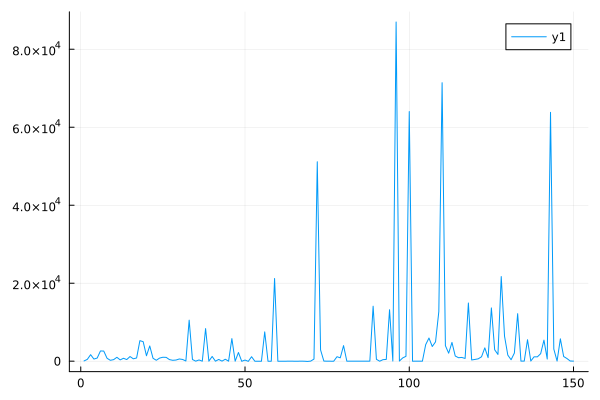

In [8]:
### Plot the stuff
plot(episode_test_reward_hook.rewards)

# plot(episode_test_reward_hook.rewards, ylim=(-25, 100))

In [ ]:
close_visualization(); # closes the MeshCat visualization